---
# AshDisperse

<p>AshDisperse is a numerical tool that solves the steady-state Advection-Diffusion-Sedimentation (ADS) Equation for a model volcanic eruption emission profile in a real wind field.</p>

<p>The solver is designed to be computationally efficient while solving the ADS equation accurately.</p>

<p>This notebook illustrates the use of AshDisperse in an interactive python session (e.g. ipython).</p>

---
## Step 1 &ndash; Import

<p>Import the <b>AshDisperse</b> package containing the Advection-Diffusion-Sedimentation equation solver, here with the import name <code>ad</code> (note the package compiles some numerical routines using numba; there is some time needed for compilation &mdash; the <code>print</code> command indicates that the package is loaded).</p>

In [6]:
%matplotlib widget
import ashdisperse as ad
import matplotlib.pyplot as plt
import numpy as np
import datetime  # loaded to report compilation is complete
print('AshDisperse compilation completed {}'.format(datetime.datetime.now()))


AshDisperse compilation completed 2024-02-26 16:42:49.625107


---
## Step 2 &ndash; Set parameters

<p>The <code>ad</code> module contains the <code>setup()</code> function that guides the user through the setup of the model, producing a <code>parameters</code> class object that contains the parameter settings needed to run a model simulation and a <code>Met</code> class object that contains meteorological data.  This uses a user input text box &ndash; look out for this appearing on screen.</p>

<p>The parameter setup involves setting a number of sets of model inputs:
<ul>
    <li>source settings</li>
    <li>grain settings</li>
    <li>emission settings</li>
    <li>solver settings</li>
    <li>physical parameters</li>
    <li>output settings</li>
    <li>model parameters</li>
    <li>meteorological data</li>
</ul>
</p>

### Source settings
<p>The source settings characterise the volcanic eruption from which ash is delivered into the atmosphere and dispersed.</p>

<p>We begin by setting the volcano source location, either as a named volcano (with location taken from the <a href="https://volcano.si.edu/">GVP Volcanoes of the World Database</a>) or as a WGS84 latitude and longitude in decimal degrees.  The location provides for georeferenced outputs and is used to extract meteorological data (see below).<p>

<p>The parameters set in the source settings are:
<ul>
    <li>the magnitude of the eruption, which characterized using a Mass Eruption Rate (MER, in kg/s) <i>(the default value of 10<sup>6</sup> kg/s, <code>MER = 1e6</code> can be used in this example)</i>;</li>
    <li>the duration of the eruption (in seconds), which is used to determine the mass loading <i>(the default value of 18000 s can be used in this example)</i>;</li>
    <li>a plume height is input to set the vertical height over which the emission occurs <i>(the default value of 10 km can be used in this example)</i>;</li>
    <li>the radius of the Gaussian source distribution in the horizontal plane <i>(the default is 10 km and can be used here)</i>;
   
The user selects either "k" or "peak" when prompted, with "k" being the default.  If "k" is selected the next query requires the user to input the Suzuki k-parameter; <i>the default value of 10 can be used</i>.  If, instead, "peak" was selected, the user is required to input the point at which the peak of the emission rate occurs as a proportion of the plume height; the default value 0.9 set the peak emission rate at an altitude of 0.9&times;plume height.</li>
</ul>    
</p>

### Grain parameters
<p>Next the grain parameters are set.  We can set multiple grain class, each with:
<ol type="i">
    <li> a diameter (which is a major factor in determining the settling speed);</li>
    <li> a density (which also contributes to the settling speed);</li>
    <li> a proportion (the mass fraction of the grain class in the total grain size distribution).</li>
</ol>
</p>

<p>In this example, set a single grain class with diameter 100 microns (entered at 1e-4), and density 1400 kg/m<sup>3</sup>.</p>

### Emission parameters
<p>The emission model adopted here is a Gaussian distribution in the horizontal (x &ndash; y) and a Suzuki-style distribution in the vertical (z).  These produce a three-dimensional spatial distribution over which the ash emission occurs.  The emission parameters determine the vertical distribution of the release.</p>

<p>It is possible to set different emission profiles for each grain class, or to have a single emission profile apply to all grain classes.</p>

<p>The emission profile is given on an interval of altitudes, which can be from sea-level up to the plume top height.</p>

<p>The parameters set in the emission settings are:
<ul>
    <li>the lower altitude of the emission profile</li>
    <li>the upper altitude of the emission profile</li>
    <li>the parameters of the Suzuki-style distribution &mdash; this can be input in one of two ways:
        <ol type="i">
            <li>either the Suzuki k-parameter is input</li>
            <li>or the altitude of the peak emission rate is specified.</li>
         </ol>
     </li>
</ul>

### Solver settings
<p>There are settings for the numerical solver that are specified in solver parameters.  In this example, the default values can be used.</p>

<p>The solver parameters are:
<ul>
    <li>Dimensionless domain size in x, domX, <i>(default value <code>domX = 1.5</code>)</i>;</li>
    <li>Dimensionless domain size in y, domY, <i>(default value <code>domY = 1.5</code>)</i>;</li>
    <li>Minimum resolution in z, minN, input as log<sub>2</sub>(minN), <i>(default value is minN = 16, <code>minN_log2 = 4</code>)</i>;</li>
    <li>Maximum resolution in z, maxN, input as log<sub>2</sub>(maxN), <i>(default value is maxN = 256, <code>maxN_log2 = 8</code>)</i>;</li>
    <li>Tolerance for Chebyshev series, epsilon <i>(default value is <code>epsilon = 1e-08</code>)</i>;</li>
    <li>Resolution in x, Nx, input as log<sub>2</sub>(Nx), <i>(default value is Nx = 256, <code>Nx_log2 = 8</code>)</i>;</li>
   <li>Resolution in y, Ny, input as log<sub>2</sub>(Ny), <i>(default value is Ny = 256, <code>Ny_log2 = 8</code>)</i>.</li>
</ul>
</p>

<p>Note, the default resolutions for the horizontal coordinates, <code>Nx_log2 = 8</code> and <code>Ny_log2 = 8</code>, are recommended as the minimum for usable output.  Lower values will compute solutions with fast runtimes but that the outputs of the calculation (illustrated below) are potentially under-resolved.  Lower values could be used as an initial check of parameter settings, followed by runs with higher resolution.  See below for details of how to update parameters.  In the example below, try setting <code>Nx_log2 = 7</code> and <code>Ny_log2 = 7</code> to get rapid results.
</p>

<p>[TODO: implement refinement to increase resolution without complete re-compute.]</p>

### Physical parameters
<p>There are also values needed for physical parameters such as diffusion coefficients.  The default values can be used in this example.</p>

<p>The physical parameters are:
<ul>
    <li>Horizontal diffusion coefficient Kappa_h <i>(default value <code>Kappa_h = 100.0</code> m^2/s)</i>;</li>
    <li>Vertical diffusion coefficient Kappa_v <i>(default value <code>Kappa_v = 10.0</code> m^2/s)</i>;</li>
    <li>Gravitational acceleration g <i>(default value <code>g = 9.81</code> m/s^2)</i>;</li>
    <li>Viscosity of air mu <i>(default <code>mu = 1.85e-05</code> kg/m/s)</i>.</li>
</ul>
</p>

### Output settings
<p>AshDisperse computes the ash concentration in three-dimensions.  The resolution the horizontal coordinates x and y are fixed. In the vertical dimension the solver uses an adaptive spectral method, so the resolution is very high but on a non-uniform mesh.  The output settings allows the user to specify a sequence of altitudes at which to access the results.  This is in addition to the ground level at z = 0.</p>

<p>The output altitudes are specified through three values:
<ol type="i">
    <li><b>Start</b> is the lowest altitude;</li>
    <li><b>Stop</b> is the highest altitude;</li>
    <li><b>Step</b> is the increment between altitudes.</li>
</ol>
The default settings provide a set of 11 altitudes between 0 and 2&times;plume height.</p>

### Meteorological conditions
<p>Meteorological conditions can be extracted from a netcdf file, or specified using a wind profile and parameters for a standard atmosphere.</p>

<p>If the user has a Copernicus ERA5 account and has setup the python API, netcdf files can be downloaded from the ERA5 repository in the required location.  Alternatively, a local netdf file can be used (perhaps that has been previously downloaded through AshDisperse), with an extent large enough to include the source location.</p>

<p>In this example we use a local netcdf file included with AshDisperse called Example.nc which is a global file so will provide meteorological conditions for any chosen volcano.  With this choice, the user must provide the path to the file.</p>

<p>If the user opts to download an ERA5 netcdf file, the volcano location specified previously is used, but a date and time for the eruption is required.  This is input in the format "YYYY-MM-DD HH:MM".</p>


In [2]:
params, Met = ad.setup()

Set parameters for AshDisperse
Set source parameters


Enter Volcano name or give latitude and longitude of source (as decimal degrees in format lat, lon):  Hekla
  Mass eruption rate  [return for default = 1000000.0] : 
  Eruption duration  [return for default = 18000.0] : 
  Plume height  [return for default = 10000.0] : 
  Gaussian source radius  [return for default = 10000.0] : 


Set grain parameters


  Number of grain classes:  :  1


Add grain class


  Grain diameter (m):  :  1e-4
  Grain density (kg/m^3):  :  1200
  Grain class proportion (0--1):  :  1


Grain parameters for AshDisperse
  Number of grain classes, N_grains = 1
  Grain class 0
    Grain diameter = 0.0001 m
    Grain density = 1200.0 kg/m^3
    Proportion = 1.0
********************
Set emission parameters


  Lower altitude for emission (m):   [return for default = 0.0] : 
  Upper altitude for emission (m):   [return for default = 10000.0] : 
  Select Suzuki emission profile parameter:  [k/peak] (default k):  
  Suzuki emission profile k-parameter  [return for default = 10.0] : 


Emission parameters for AshDisperse
  Number of emission profiles = 1
  Emission profile for grain class 0
    Lower altitude = 0.0 m
    Upper altitude = 10000.0 m
    Suzuki k = 10.0
    Suzuki peak = 9000.0 m
********************
Set solver parameters
Solver parameters for AshDisperse
  Dimensionless domain size in x, domX = 1.5
  Dimensionless domain size in y, domY = 1.5
  Minimum resolution in z, minN = 16, (minN_log2 = 4)
  Maximum resolution in z, maxN = 256, (maxN_log2 = 8)
  Number of Chebyshev iterates = 5
  Tolerance for Chebyshev series, epsilon = 1e-08
  Resolution in x, Nx = 256, (Nx_log2 = 8)
  Resolution in y, Ny = 256, (Ny_log2 = 8)
********************


Change solver parameters?  [y/N] : 


Set physical parameters
Physical parameters for AshDisperse
  Horizontal diffusion coefficient Kappa_h = 100.0 m^2/s 
  Vertical diffusion coefficient Kappa_v = 10.0 m^2/s 
  Gravitational acceleration g = 9.81 m/s^2 
  Viscosity of air mu = 1.85e-05 kg/m/s 
********************


Change physical parameters?  [y/N] : 


Set output parameters
Output parameters for AshDisperse
  Altitudes = [    0.  2000.  4000.  6000.  8000. 10000. 12000. 14000. 16000. 18000.
 20000.] m 
********************


Change output parameters?  [y/N] : y
  Lower altitude  [return for default = 0.0] : 
  Upper altitude  [return for default = 20000.0] : 11000
  Altitude step  [return for default = 2000.0] : 500


Set up meteorological inputs


Source of meteorological data: 
   0 -> local netcdf file 
   1 -> download ERA5 data 
   2 -> standard atmosphere 
   3 -> GFS forecast 
   4 -> GFS archive 
 [0/1/2/3/4] (default 0):  3
Date and time for meteorological data (as yyyy-mm-dd hh:mm) : 2024-02-26 12:00


/opt/anaconda3/envs/ash_dev/lib/python3.11/site-packages/siphon/ncss.py:432: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arrs = np.genfromtxt(fobj, dtype=None, names=names, delimiter=',',


Set physical parameters
Physical parameters for AshDisperse
  Horizontal diffusion coefficient Kappa_h = 100.0 m^2/s 
  Vertical diffusion coefficient Kappa_v = 10.0 m^2/s 
  Gravitational acceleration g = 9.81 m/s^2 
  Viscosity of air mu = 1.85e-05 kg/m/s 
********************


Change physical parameters?  [y/N] : 


Set output parameters
Output parameters for AshDisperse
  Altitudes = [    0.  2000.  4000.  6000.  8000. 10000. 12000. 14000. 16000. 18000.
 20000.] m 
********************


Change output parameters?  [y/N] : 


Set up meteorological inputs


Source of meteorological data: 
   0 -> local netcdf file 
   1 -> download ERA5 data 
   2 -> standard atmosphere 
   3 -> GFS forecast 
   4 -> GFS archive 
 [0/1/2/3/4] (default 0):  3
Date and time for meteorological data (as yyyy-mm-dd hh:mm) : 2023-12-31 12:00


---
## Step 3 &ndash; Accessing and Visualizing Meteorological data

<p>Having loaded the meteorological data during setup, it is available to us as the <code>Met</code> class instance.  We can access the data and visualize using methods of the <code>Met</code> class.</p>

<p>The following methods return data as numpy arrays, with <code>z</code> as a suitable numpy array of altitudes:
    <ul>
        <li><code>temperature(z)</code> -- atmospheric temperature (K);</li>
        <li><code>pressure(z)</code> -- atmospheric pressure (Pa);</li>
        <li><code>getDensity(z)</code> -- atmospheric density (kg/m<sup>3</sup>, calculated from temperature and pressure assuming an ideal gas of dry air;</li>
        <li><code>wind_U(z)</code> -- the U-component (easting) wind velocity profile (m/s);</li>
        <li><code>wind_V(z)</code> -- the V-component (northing) wind velocity profile (m/s);</li>
        <li><code>wind_speed(z)</code> -- the wind speed profile (m/s).</li>
    </ul>
These methods can be used to plot the meteorological profiles, as illustrated below.
</p>

<p>Plotting the meteorological data allows us to assess these important inputs to the model &mdash; are the wind speeds (in particular) sensible?  If not, consider using a different meteorological file.</p>

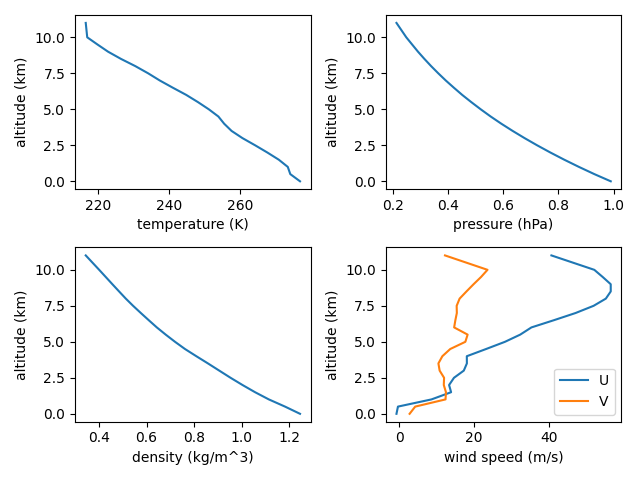

In [7]:
z = params.output.altitudes
fig, axs = plt.subplots(2,2)
axs[0,0].plot(Met.temperature_array(z),z/1e3)
axs[0,0].set_xlabel('temperature (K)')
axs[0,0].set_ylabel('altitude (km)')
axs[0,1].plot(Met.pressure_array(z)/1e5,z/1e3)
axs[0,1].set_xlabel('pressure (hPa)')
axs[0,1].set_ylabel('altitude (km)')
axs[1,0].plot(Met.density_array(z),z/1e3)
axs[1,0].set_xlabel('density (kg/m^3)')
axs[1,0].set_ylabel('altitude (km)')
axs[1,1].plot(Met.wind_U_array(z),z/1e3,label='U')
axs[1,1].plot(Met.wind_V_array(z),z/1e3,label='V')
axs[1,1].legend()
axs[1,1].set_xlabel('wind speed (m/s)')
axs[1,1].set_ylabel('altitude (km)')
plt.tight_layout()
plt.show()

<p>Additionally, it is possible to visualize the wind profile using directional plot, illustrated below, where the length of the wind vector indictes wind speed and the direction to which the wind blows.  The colour of vector denotes the altitude.  This plot is produced with the module function <code>AD.windPlot()</code> with the required arguments of the <code>Met</code> class instance and an array of altitudes <code>z</code>.</p>

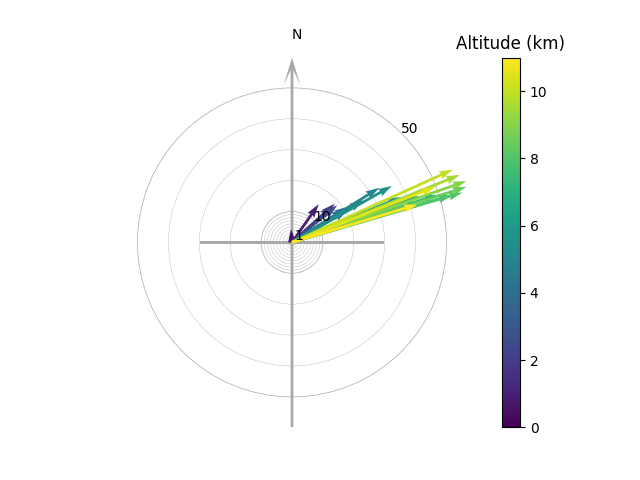

In [8]:
ad.wind_plot(Met,z)

<p>Additionally, there is a method within the <code>Met</code> class, <code>Met.settling_speed(params,z)</code> that calculates and returns the settling speed of the grains.  <code>ws = Met.settling_speed(params,z)</code> returns the settling speed of each grain class as an array with a column for each grain class.  Note, the settling speed is not constant due to the variation of the atmospheric density with altitude.</p>

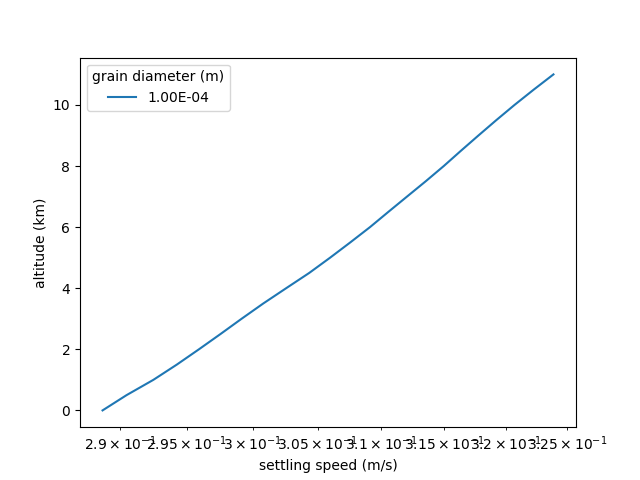

In [9]:
ws = Met.settling_speed_array(params,z)
fig, ax = plt.subplots()
for igrain in range(params.grains.bins):
    ax.semilogx(ws[:,igrain],z/1e3,label="{:.2E}".format(params.grains.diameter[igrain]))
ax.set_xlabel('settling speed (m/s)')
ax.set_ylabel('altitude (km)')
ax.legend(title='grain diameter (m)')
plt.show()

---
## Step 4 &ndash; Calculating ash dispersion

<p>When the model setup is complete, you have the <code>params</code> structure containing the parameters needed for running the model, and a <code>Met</code> object that stores the required meteorological profiles.  With this data we are able to calculate an ash dispersion pattern.</p>

<p>Running the calculation is simple, using the <code>ad.solve(params,Met)</code> function.  Note, the solution proceedure involves solving a large number of differential equations, for each grain class; while the solver algorithm is efficient and accurate, it may still take some time for the solver routine to complete.</p>

<p>The calculation can be sped-up by using parallel processing.  AshDisperse uses open-mp parallelization, and the number of threads can be set in AshDisperse.  This is done using the <code>config</code> module.</p>

<p>The code below reports the threading layer and number of available threads, and then sets the number of threads to be used in the calculation.</p>

In [10]:
print(f"Threading layer is {ad.config.get_threading_layer()}")
print(f"Number of threads available = {ad.config.get_max_threads()}")
ad.config.set_num_threads(3)
print(f"Number of threads for computation = {ad.config.get_num_threads()}")

Threading layer is omp
Number of threads available = 8
Number of threads for computation = 3


<p>In the call to <code>solve</code> below, the results are stored in an <code>AshDisperseResult</code> class object called <code>result</code>.  We describe this class further below.  Note, the call also has an optional <code>timer</code> argument that times aspects of the calculation and reports these on completion.</p>

In [11]:
result = ad.solve(params,Met,timer=True)

Equation solve time :  75.8484582901001
Inverse FFT time :  0.06479310989379883
Total solve time :  75.9132513999939


---
## Step 5 &ndash; AshDisperse results

<p>To understand the <code>result</code> object, it is useful to give some background on some aspects of the solver.</p>

<p>The ADS equation is solved for each grain class, with an assumption that the motion of each grain class is independent from other grain classes.  For each grain class, the settling speed relative to the advective wind speeds is a key parameter in determining the length scale of dispersion.  Therefore, each grain class has a distinct length scale for the dispersion and this is built into the solver.  In the <code>result</code> object, we are able to access the length scales for each grain class and produce results that have an appropriate extent and resolution.</p>

<p>The scaling applied to each grain class is determined as part of the parameters set up, so are available in the <code>params</code> object; for convenience, the parameters are also available within the <code>result</code> object, as shown below.<p>

In [12]:
print(f"xyScale = {result.params.model.xyScale}")

xyScale = [2087160.40309515]


<p>These indicate the anticipated scale of dispersal i.e. the distance a grain would fall from the top of the eruption column/umbrella cloud with a constant wind speed equal to the maximum over the emission profile and without diffusion.</p>

<p>The value of <code>xyScale</code> above is the horizontal length scale for the grain classes.</p>

<p>The <code>AshDisperseResults</code> class contains a few properties and several methods.  Typically the results we are interested in are accessed through the class methods.</p>

<p>AshDisperse calculates directly the concentration in three-dimensions and the settling flux at ground level.</p>

### Plotting the settling flux
<p>The settling flux is contained in the class property <code>result.SettlingFlux</code> which is a three-dimensional <code>numpy</code> array.  The two-dimensional array <code>result.SettlingFlux[:,:,j]</code> contains the settling flux for the grain class <code>j</code>.  This can be plotted through the class method <code>result.plot_settling_flux_for_grain_class(j)</code>, as illustrated below.</p>

/opt/anaconda3/envs/ash_dev/lib/python3.11/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
/opt/anaconda3/envs/ash_dev/lib/python3.11/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))


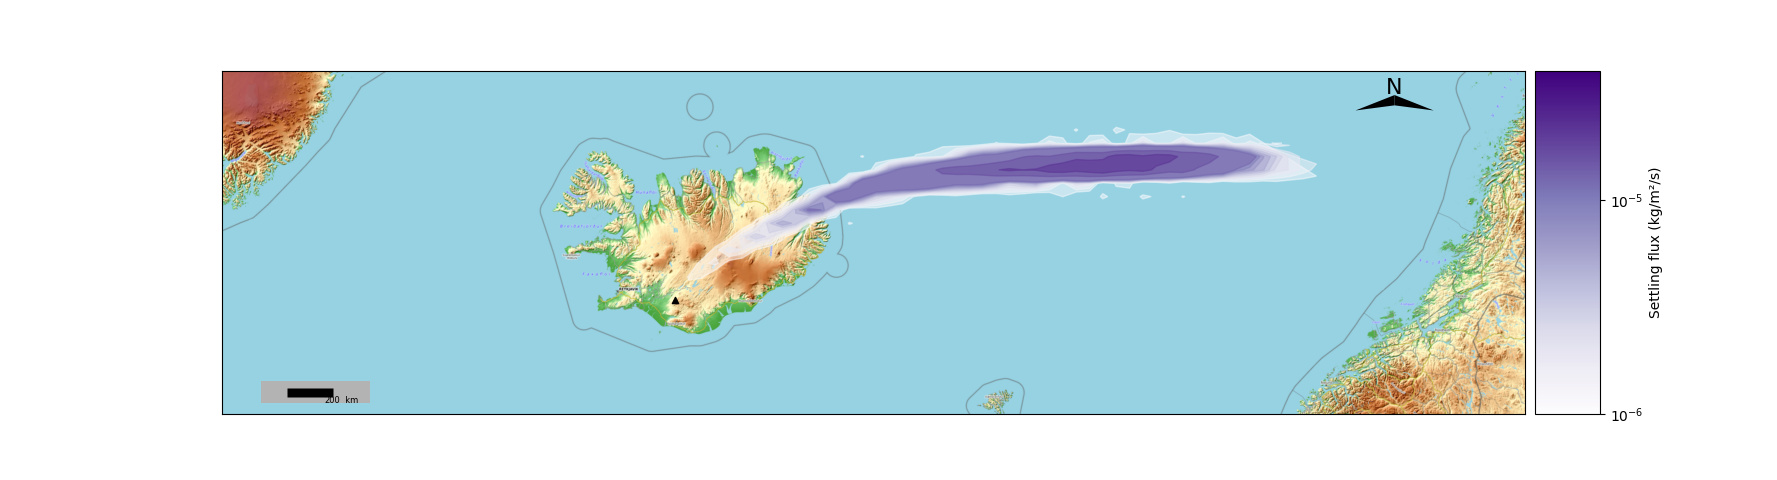

In [13]:
fig, ax, cbar = result.plot_settling_flux_for_grain_class(0)

<p>We note that dimensional axes appropriate for the request grain class have automatically been used, and that these are larger than the 'natural' length scale.  This is because AshDisperse ensures:
<ol type="i">
    <li>the domain is large enough to account for diffusive transport, in addition to advection;</li>
    <li>the domain of the calculation is larger so that it is likely that the ash concentration is negligible at the domain edges;</li>
    <li> the domain is taken to be larger than the source area if large grains that fall rapidly.</li>
</ol>
</p>

<p>Also note that the colour scale is automatically selected and by default is a logarithmic scale (which is typically suitable given order-of-magnitude changes in the settling flux with position.  The default lower limit of the scale is 10<sup>-6</sup> kg/m<sup>2</sup>/s; lower values often require a high resolution.  The upper limit is determined automatically by default based on the result, so will vary for each grain class.</p>

<p>The <code>plot_settling_flux_for_grain_class()</code> method has optional arguments that help to style the plot:
<ul>
    <li><code>logscale=True</code> specifies whether to use a logarithmic scale &ndash; set to <code>False</code> for a linear scale (but note this is often not a good representation of the data;</li>
    <li><code>vmin=1e-6</code> sets the minimum data value below which data is cut;</li>
    <li><code>cmap=plt.cm.Purples</code> sets the colour map for the plot &ndash; use a valid <code>matplotlib</code> colormap.
</ul>
</p>

### Plotting the ash loading for a grain class
<p>It is also possible to plot the ash loading at ground level for each grain class.  This is done through the class method <code>result.plot_ashload_for_grain_class(j)</code>, as illustrated below.</p>

<p>Note, under the steady-state approximation, the ash loading is simply the settling flux multiplied by the duration of the eruption.</p>

<p>The method <code>plot_ashload_for_grain_class()</code> shares the same optional arguments as <code>plotSettlingFlux()</code>, with different default values (<code>vmin=1e-3</code>, <code>cmap=plt.cm.plasma</code>).</p>

<p>We will see later how to construct the cumulative ash loading using all grain classes.</p>

/opt/anaconda3/envs/ash_dev/lib/python3.11/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
/opt/anaconda3/envs/ash_dev/lib/python3.11/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))


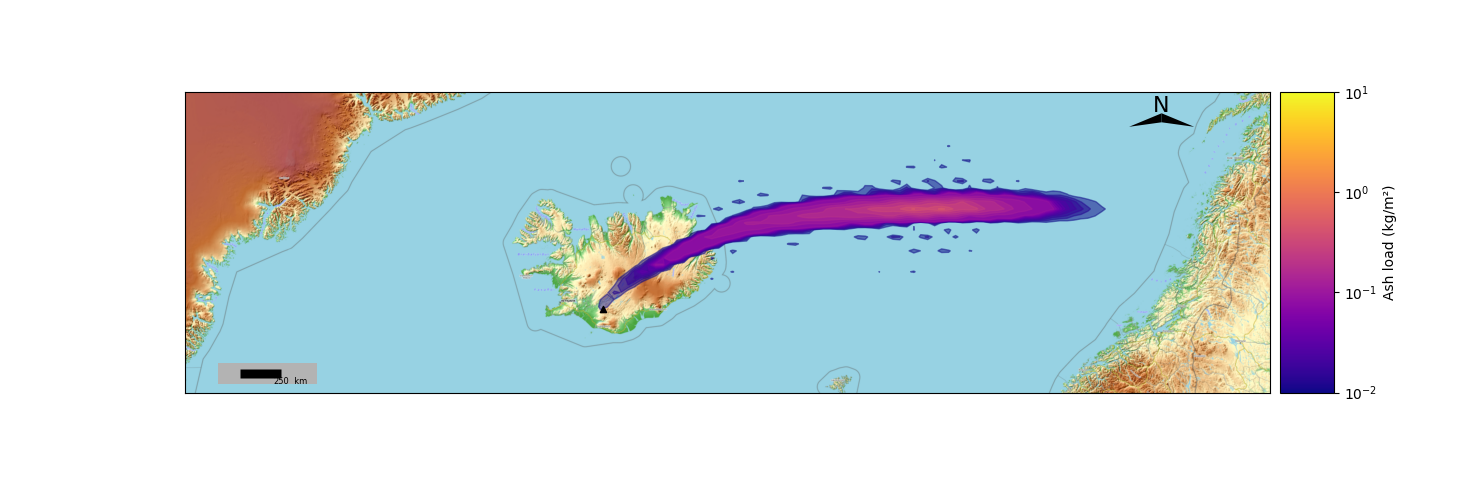

In [14]:
fig, ax, cbar = result.plot_ashload_for_grain_class(0, basemap=True)

### Plotting the concentration
<p>The concentration can also be plotted, and there are two methods providing this.  The first is a simple collection of slices at different heights, through the <code>plot_conc_for_grain_class()</code> method, which again requires the grain class index, as illustrated below.</p>

<p>The slices are shown at the output altitudes, given in <code>params.output.altitudes</code>.  There are the same optional arguments as <code>plot_settling_flux_for_grain_class()</code>.</p>

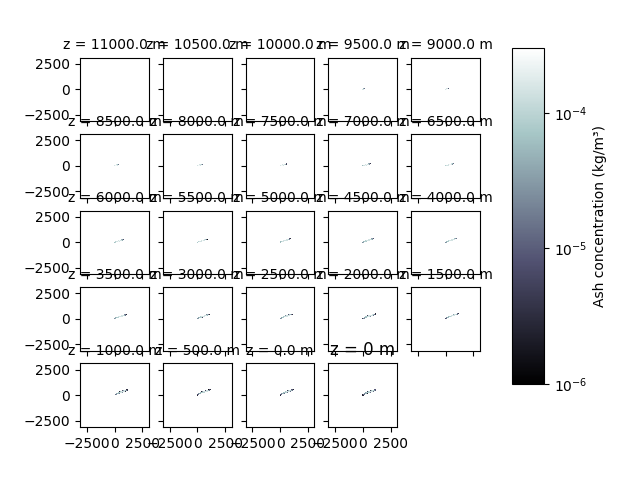

In [15]:
fig, ax, cbar = result.plot_conc_for_grain_class(0)

<p>Arguably a more interesting plot is provided by the method <code>plot_iso_conc_for_grain_class(j, conc)</code> which plots an iso-surface of concentration in three dimensions.</p>

<p>The two required arguments are the grain index <code>j</code> and the concentration level (in kg/m<sup>3</sup>) <code>conc</code>.</p>

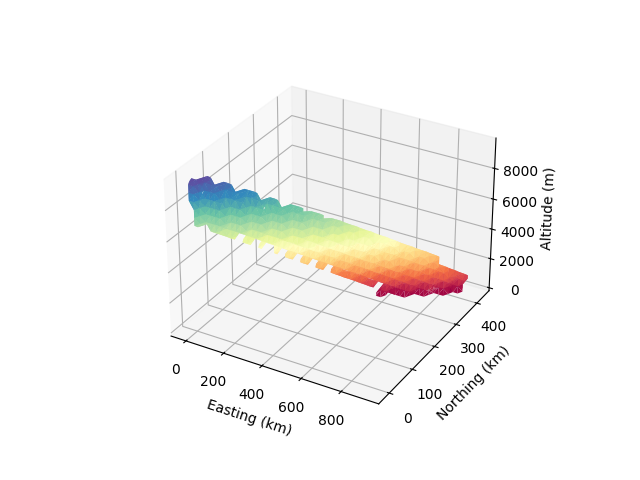

In [16]:
result.plot_iso_conc_for_grain_class(0, 1e-4)

<p>This image illustrates a surface containing regions of space where the concentration is greater than the specified <code>conc</code> level.  The colouring of the suface indicates the altitude of the surface element to aid interpretation.</p>

### Retrieving the cumulative ash loading
<p>Perhaps the most valuable output from AshDisperse is the cumulative ash loading from all grain classes.</p>

<p>Since each grain class has it's own 'natural' length scale, it is not possible to simply sum the ash loading for each grain class.  Instead, AshDisperse provides a method for extracting the cumulative ash loading as a <code>numpy</code> array.

<p>The total ash loading is produced by the <code>get_ashload()</code> method.  As illustrated below.</p>

<p><code>get_ashload()</code> has several optional keyword arguments:
<ul>
    <li><code>resolution=300.</code> &mdash; this is a crucial setting which determines the resolution (in metres) of the output data;</li>
    <li><code>vmin=1e-3</code> &mdash; the lower bound for the ash loading below which data is masked;</li>
    <li><code>export_GTiff=True</code> &mdash; an option to export the data to a georeferenced tiff (geotiff) file;</li>
    <li><code>export_name='AshLoad.tif'</code> &mdash; the file name for the geotiff file produced if <code>export_gtiff=True</code>.
</ul>
<b>Warning</b>: carefully consider the appropriate resolution, since the extent of the cumulative data is set by the largest extend of the dispersal of the constituent grain classes.  Therefore, a small spatial resolution may create an extremely large data set.  Executing this method will report the width and height of the output data.
</p>

<p>The <code>get_ashload()</code> returns three <code>numpy</code> arrays, x, y and the total ash load, and therefore should be called using <code>x, y, totalLoad = get_ashload()</code>.  Note, here x and y are distances in metres from in the appropriate local UTM coordinate reference system.</p>

<p>If further processing is not required (i.e. export to geotiff is sufficient), call as <code>_, _, _ = get_ashload()</code>.</p>

In [18]:
# get cumulative ash loading at a resolution of 1 km
# with a lower bound of 0.01 kg/m^2
# No export in this notebook example -- switch export_GTiff=True to export
x, y, totalLoad = result.get_ashload(resolution=1000, vmin=0.01, export_gtiff=False)

Output raster shape is (6215,1347)


<p>As an example, the maximum ash load and it's location can be found using <code>numpy</code>.</p>

In [20]:
j, i = np.unravel_index(np.argmax(totalLoad, axis=None), totalLoad.shape)
maxLoad = totalLoad[j,i]
xmax = x[i]
ymax = y[j]
print(
    f'Maximum ash load is {maxLoad:.2f} kg/m^2'
    + f' at a location {xmax/1000:.2f} km East, {ymax/1000:.2f} km North of the vent'
    + f' in the epsg:{params.source.utmcode} coordinate reference system')

Maximum ash load is 0.84 kg/m^2 at a location 797.00 km East, 391.00 km North of the vent in the epsg:32627 coordinate reference system


### Plotting cumulative ash load
<p>A plot of the cumulative ash load can be produced using the <code>plot_ashload()</code> method, which has an internal call to <code>get_ashload()</code> and therefore adopts it's optional keyword arguments (so <code>plot_ashload()</code> can be used to export as a geotiff &ndash; note, the default here is to not export the geotiff, i.e. <code>export_gtiff=False</code>).  Additionally, there are plotting optional arguments:
<ul>
    <li><code>logscale=True</code></li>
    <li><code>cmap=plt.cm.viridis</code></li>
</ul>
</p>

<p>Note, if exporting a geotiff through <code>plot_ashload()</code>, the <code>vmin</code> parameter in the exported data will be set to <code>vmin/10</code>.  This is to ensure the data extends below the lower bound for the contouring in the plot.</p>

/home/mw9428/Documents/AshModel/ashdisperse/ashdisperse/core/results.py:1294: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/opt/anaconda3/envs/ash_dev/lib/python3.11/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
/opt/anaconda3/envs/ash_dev/lib/python3.11/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))


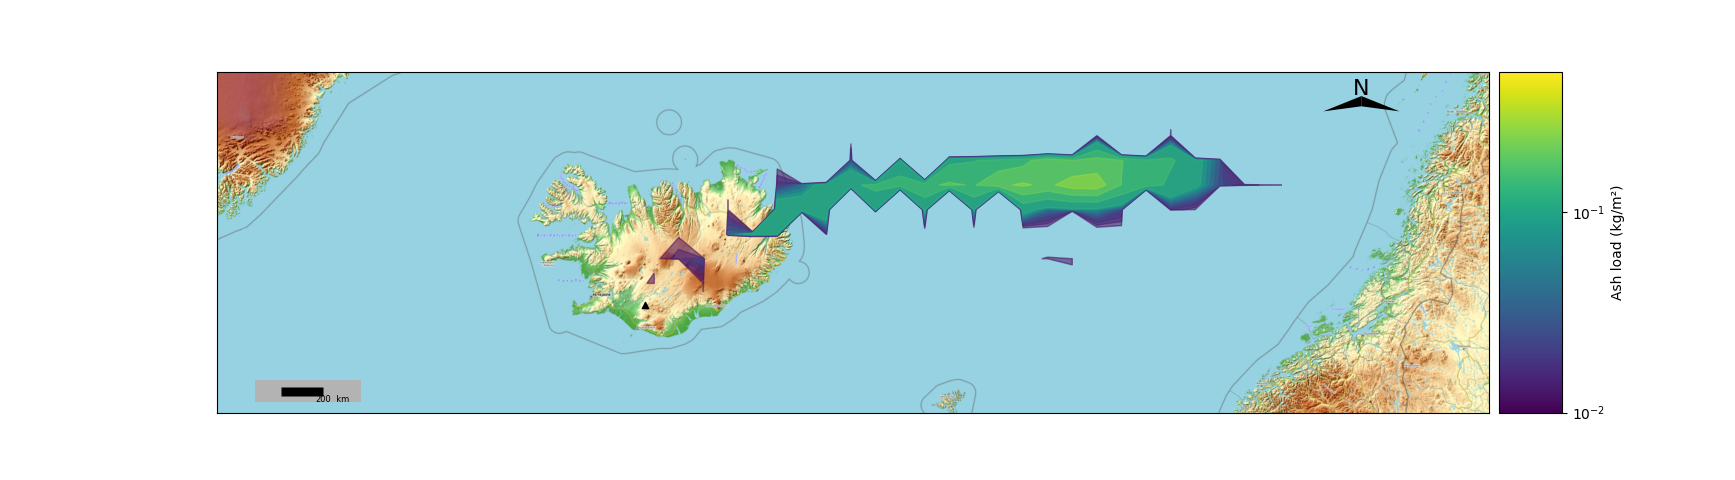

In [33]:
fig, ax, cbar = result.plot_ashload(resolution=300, vmin=0.01, basemap=True)

<p>Note that if the value of <code>vmin</code> is low, then the low resolution of the result will be visible as structured numerical noise.  This can be removed by using a higher horizontal resolution.</p>

---
## Additional functionality

---
## Saving parameters and meteorological inputs
<p>The parameters and meteorological data can be saved so that they can be stored and reused.</p>

### Meteorological data
<p>To save the meteorological data, use the <code>ad.save_met(Met, file='meteorology.npz')</code> method.  This has one required argument, the <code>MetData</code> object, and one optional argument <code>file</code> which specifies the output file name.</p>

<p>The file format is a <code>numpy .npz</code> file.</p>

### Parameters

<p>To save the parameters, use the <code>ad.save_parameters(params, file='parameters.txt')</code> method.  This has one required argument, the <code>parameters</code> object, and one optional argument <code>file</code> which specifies the output file name.</p>

<p>The file format is an ascii <code>.txt</code> file.</p>

---
## Loading parameters and meteorological inputs
<p>Parameters and meteorological data saved through AshDisperse can be loaded and used to re-compute results.</p>

### Meteorological data

<p>Meteorological data can be loaded using the command <code>Met1 = ad.load_met('meteorology.npz')</code> which has one required argument, the filename of the <code>.npz</code> meteorological file.  The method returns an AshDisperse <code>MetData</code> object.</p>

<p>Meteorological data should be loaded before paramters as the <code>parameters</code> object requires a <code>MetData</code> object.</p>

### Parameters
<p>Once the <code>MetData</code> object is available (either by loading or from an existing object produced by <code>ad.Setup()</code>), saved parameters can be loaded using the <code>params1 = ad.load_parameters('parameters.txt',Met1)</code> method, which has two required arguments: the filename of the <code>.txt</code> parameters file and the <code>MetData</code> object.</p>

---
## Copying and updating parameters
<p>It is often useful to alter a set of parameters to produce a companion simulation for comparison.  For example, in conducting a stochastic uncertainty analysis we will need to vary source and physical parameters (as well as meteorological inputs).</p>

<p>To facilitate this, AshDisperse includes a method for copying parameters and a method for updating parameters.  These should be used together to efficiently make new input parameters.</p>

#### 1. Copying
<p>The method <code>ad.copy_parameters(params)</code> is used to copy parameters, as illustrated below.  There is a required argument, the <code>parameters</code> object to be copied, and a new <code>parameters</code> object is returned.</p>

In [41]:
params_update = ad.copy_parameters(params)

#### 2. Updating
<p>The method <code>ad.update_parameters(params_update, Met)</code> is used to update a <code>parameters</code> object.  There are two required parameters: <code>params_update</code> is the <code>parameters</code> object that is updated; <code>Met</code> is a <code>MetData</code> object that will be used in computing results.  A <code>parameters</code> object is returned, which is sensibly the same object that is input.</p>

<p><code>update_parameters</code> has a large number of optional parameters, which are each AshDisperse parameters:
<ul>
    <li><code>Lx=None</code> &ndash; Dimensionless domain size in x;</li>
    <li><code>Ly=None</code> &ndash; Dimensionless domain size in y;</li>
    <li><code>minN_log2=None</code> &ndash; log<sub>2</sub> of the minimum resolution in z;</li>
    <li><code>maxN_log2=None</code> &ndash; log<sub>2</sub> of the maximum resolution in z;</li>
    <li><code>epsilon=None</code> &ndash; tolerance for Chebyshev series;</li>
    <li><code>Nx_log2=None</code> &ndash; log<sub>2</sub> of the resolution in x;</li>
    <li><code>Ny_log2=None</code> &ndash; log<sub>2</sub> of the resolution in y;</li>
    <li><code>grains=None</code> &ndash; grain parameter settings, described further below;</li>
    <li><code>latitude=None</code> &ndash; latitude of the eruption source in decimal degrees;</li>
    <li><code>longitude=None</code> &ndash; longitude of the eruption source in decimal degrees;</li>
    <li><code>radius=None</code> &ndash; Gaussian source radius in metres;</li>
    <li><code>PlumeHeight=None</code> &ndash; Plume height in metres;</li>
    <li><code>MER=None</code> &ndash; Mass eruption rate in kg/s;</li>
    <li><code>duration=None</code> &ndash; Eruption duration is seconds;</li>
    <li><code>Suzuki_k=None</code> &ndash; Suzuki emission profile k-parameter;</li>
    <li><code>Suzuki_peak=None</code> &ndash; Suzuki emission profile peak-parameter;</li>
    <li><code>Kappa_h=None</code> &ndash; Horizontal diffusion coefficient in m<sup>2</sup>/s;</li>
    <li><code>Kappa_v=None</code> &ndash; Vertical diffusion coefficient in m<sup>2</sup>/s;</li>
    <li><code>g=None</code> &ndash; Gravitational acceleration in m/s<sup>2</sup>;</li>
    <li><code>mu=None</code> &ndash; Viscosity of air in kg/m/s;</li>
    <li><code>start=None</code> &ndash; the lowest altitude for output in metres;</li>
    <li><code>stop=None</code> &ndash; the highest altitude for output in metres;</li>
    <li><code>step=None</code> &ndash; the increment between output altitudes in metres;</li>.
</ul>
</p>

<p>As an example, to update the x and y resolution of the calculation from 128&times;128 to 256&times;256, the following call would be made:</p>

In [43]:
params_update = ad.update_parameters(params_update, Met, Nx_log2=8, Ny_log2=8)

<p>The updated parameters can be viewed, and the <code>parameters</code> object contains a <code>describe()</code> method (and <code>describe()</code> methods for each sub-class) which produces informative summary information. </p>

In [44]:
params_update.solver.describe()

Solver parameters for AshDisperse
  Dimensionless domain size in x, Lx =  1.5
  Dimensionless domain size in y, Ly =  1.5
  Minimum resolution in z, minN =  16  (minN_log2 =  4 )
  Maximum resolution in z, maxN =  256  (maxN_log2 =  8 )
  Number of Chebyshev iterates =  5
  Tolerance for Chebyshev series, epsilon =  1e-08
  Resolution in x, Nx =  256  (Nx_log2 =  8 )
  Resolution in y, Ny =  256  (Ny_log2 =  8 )
********************


<p>These updated parameters can be used to generate new results.  With the higher spatial resolution, the runtime is expected to increase by approximately a factor of four.</p>

In [45]:
result_update = ad.solve(params_update,Met,timer=True)

Equation solve time :  343.2449767589569
Inverse FFT time :  0.041242122650146484
Total solve time :  343.28621888160706


Output raster shape is (123,127)


<IPython.core.display.Javascript object>


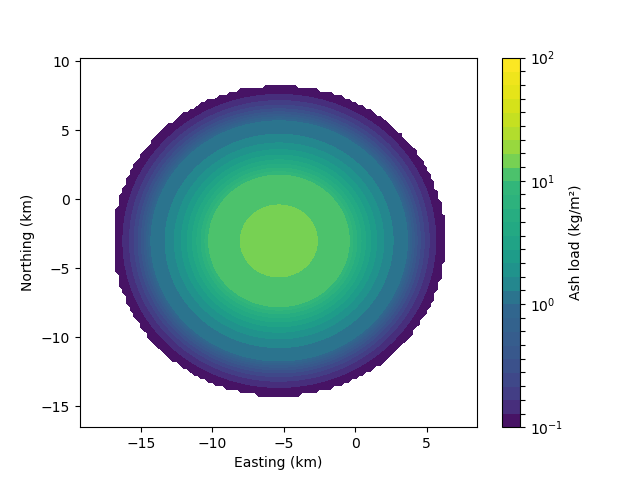

In [46]:
result_update.plot_ashload(resolution=250, vmin=0.1)

#### Updating the grain classes
<p>The grain classes are updated using the <code>grains</code> optional argument of <code>update_parameters</code>.  This requires a particular format since each grain class requires defining characteristics.</p>

<p>The <code>grains</code> input takes the form of a list of dictionaries, with each dictionary having the keys <code>'class'</code>, <code>'diameter'</code>, <code>'density'</code>, and <code>'proportion'</code>.</p>

<p>As an example, if we wish to update parameters to have two grain classes, one of diameter 1 mm representing 20% of the total erupted, and the other with diameter 100 microns, the following command could be used.</p>

In [47]:
p2 = ad.copy_parameters(params)
p2 = ad.update_parameters(p2, Met, grains=[
    {'class':1, 'diameter':1e-3, 'density':1400, 'proportion':0.2},
    {'class':2, 'diameter':1e-4, 'density':1400, 'proportion':0.8},
])

<p>We can then proceed to compute the results.</p>

In [48]:
result2 = ad.solve(p2, Met, timer=True)

Equation solve time :  543.9212582111359
Inverse FFT time :  0.09500312805175781
Total solve time :  544.0162613391876


Output raster shape is (2365,2365)


<IPython.core.display.Javascript object>


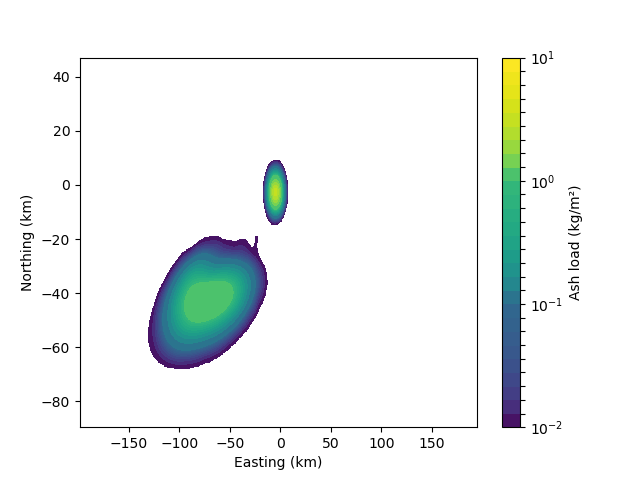

In [53]:
result2.plot_ashload(resolution=500, vmin=1e-2)